In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import plotly
import datetime
import collections

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout, ReLU, Embedding
from keras.activations import sigmoid, relu
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.models import Sequential

sns.set()

In [49]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

### Ok, we now ready for start! Here we go @fabriziorom

In [53]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])

In [54]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


In [ ]:
def print_nunique_nnan(dataset, columns):
  for column in columns:
    print(column + ":")
    print(len(dataset[column].unique()))
    print(len(dataset[column][dataset[column].isna() == True]))

columns = ['date', 'street_id', 'build_tech', 'floor', 'rooms', 'balcon',
           'g_lift',
           'n_photos',
           'kw1']

print_nunique_nnan(dataset = prices_dataset, columns = columns)

date:
18
0
street_id:
672
0
build_tech:
4
29735
floor:
25
0
rooms:
6
0
balcon:
3
0
g_lift:
3
29992
n_photos:
12
0
kw1:
2
0


### Not so a lot information right now. Let's dive into deeper analysis.

In [ ]:
prices_dataset['date'] = prices_dataset['date'].astype('str')

prices_dataset['date'] = pd.to_datetime(prices_dataset['date'], format = '%Y-%m').dt.strftime("%Y-%m")
# prices_dataset.head()

### Let's try to build histplot showing the dates-prices distribution.

In [ ]:
prices_dataset['price']

In [55]:
def plot_distribution(ylim, hue):
  figure = plt.figure(figsize = (10, 5))

  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-1,1))
  plt.gca().xaxis.set_major_formatter(formatter)

  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'], alpha = 0.5)
  plt.title(f'Price-{hue} distribution for prices')
  plt.ylim([0, ylim])

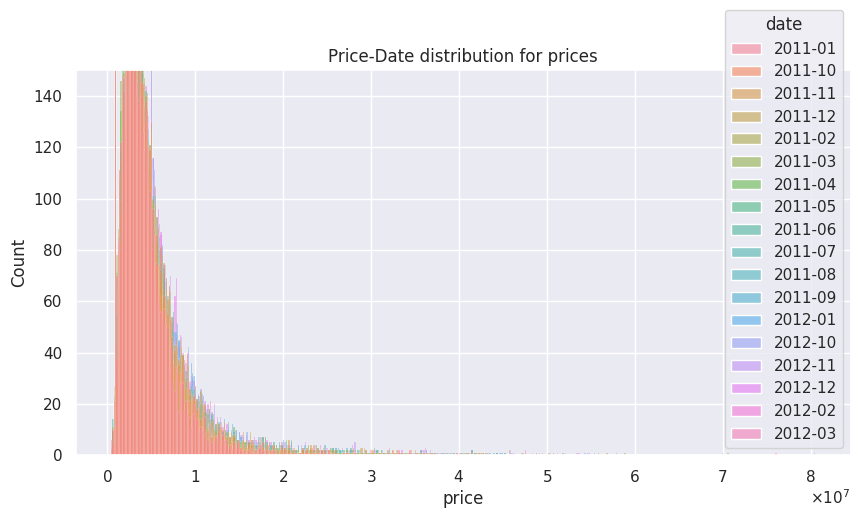

In [ ]:
plot_distribution(150, 'date')

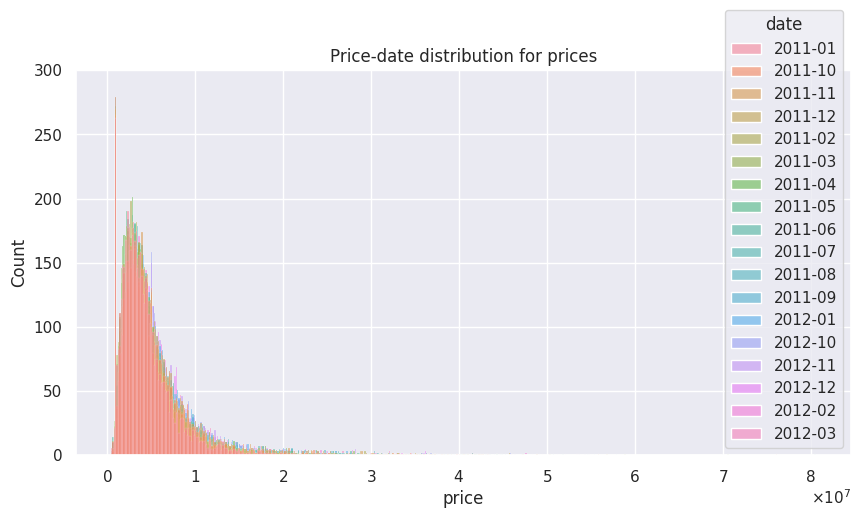

In [ ]:
plot_distribution(300, 'date')

### So, looks like to be similar distributions right there. We may notice that old and fresh flats could be both expensive and cheap. But let's try to divide the whole period and take the half.

In [ ]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])
prices_dataset['date'] = pd.to_datetime(prices_dataset['date'])
all_dates = prices_dataset['date']

print(f'Max date is {all_dates.max()}')
print(f'Min date is {all_dates.min()}')
print(f'Median date is {all_dates.median()}')

Max date is 2012-12-01 00:00:00
Min date is 2011-01-01 00:00:00
Median date is 2011-09-01 00:00:00


In [ ]:
before_median_date = prices_dataset[prices_dataset['date'] < all_dates.median()]
after_median_date = prices_dataset[prices_dataset['date'] >= all_dates.median()]

prices_dataset['flag_before_after'] = prices_dataset['date'] >= all_dates.median()
# prices_dataset.head()

In [ ]:
prices_dataset['flag_before_after'] = prices_dataset['flag_before_after'].astype(int)

### And Let's look for the distribution:

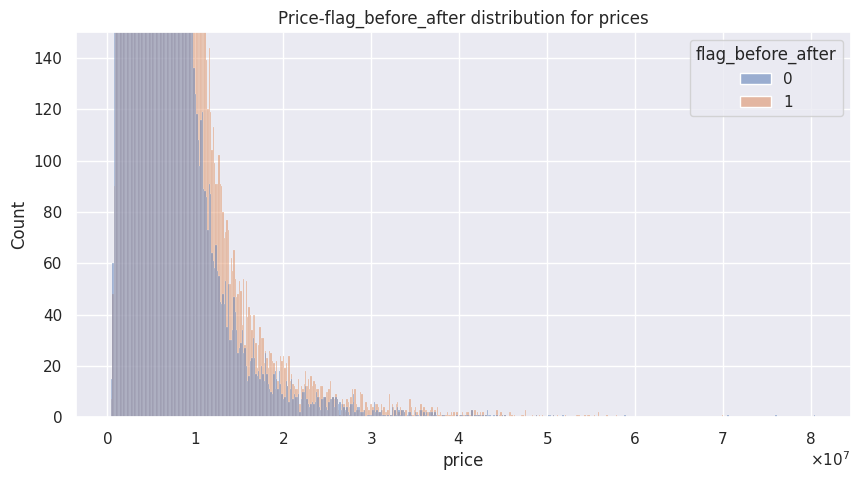

In [ ]:
plot_distribution(ylim = 150, hue = 'flag_before_after')

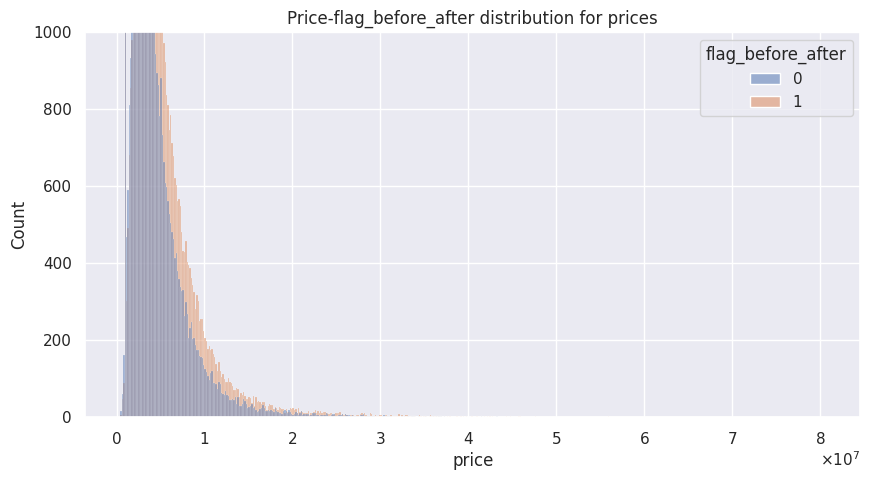

In [ ]:
plot_distribution(ylim = 1000, hue = 'flag_before_after')

### So, the difference is shown btw. I wanna try 3 periods.

In [ ]:
max_date = prices_dataset['date'].max()
min_date = prices_dataset['date'].min()

median_date = prices_dataset['date'].median()

first_midpoint = min_date + (median_date - min_date) / 2

second_midpoint = median_date + (max_date - median_date) / 2


def three_periods_divison(date, first_midpoint, second_midpoint):
  if date < first_midpoint:
    return 1
  elif first_midpoint <= date < second_midpoint:
    return 2
  else:
    return 3

prices_dataset['three_periods'] = prices_dataset['date'].apply(three_periods_divison,
                                                               args = (first_midpoint,
                                                                       second_midpoint))

print(f"Max date is: {max_date}")
print(f"Мin date is: {min_date}")
print("First mid point:")
print(first_midpoint)
print("Second mid point:")
print(second_midpoint)

Max date is: 2012-12-01 00:00:00
Мin date is: 2011-01-01 00:00:00
First mid point:
2011-05-02 12:00:00
Second mid point:
2012-04-16 12:00:00


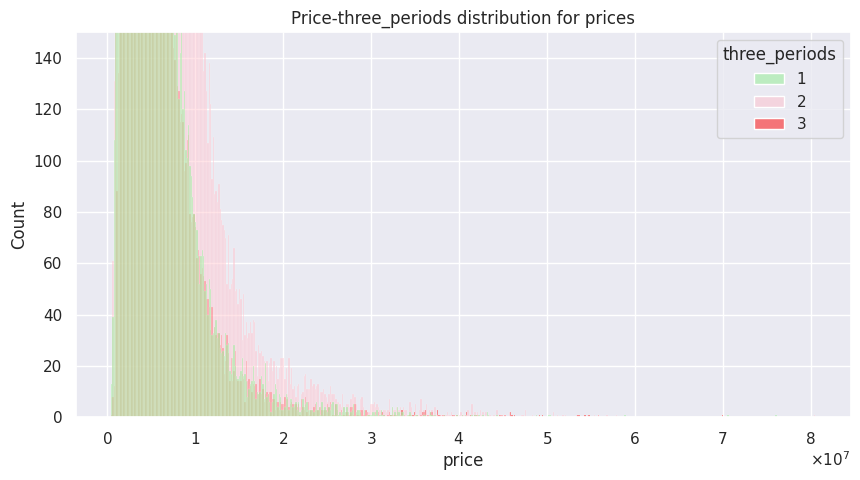

In [ ]:
plot_distribution(ylim = 150, hue = 'three_periods')

### So, I assume the double date division to be solid. So, probably, I'll convert date feature to True/False depending on the before/after mid_date. Go on!

### Let's have a view on the street_id feature:

In [56]:
street_id = prices_dataset['street_id']

In [57]:
street_id.nunique()

672

#### So, we have 672 unique street with having no idea about it's qualities and price impact. But in real life of coure street for example in the center increases the flat's price. I wanna try to test hypothesis and sort by street_id.

In [ ]:
prices_dataset = prices_dataset.sort_values(by=['street_id'], ascending = True)

In [ ]:
median_street_id = prices_dataset['street_id'].median()
median_street_id

334.0

In [ ]:
prices_dataset['street_id_flag'] = prices_dataset['street_id'] > median_street_id
prices_dataset['street_id_flag'] = prices_dataset['street_id_flag'].astype(int)

<ipython-input-97-2f84608c91d3>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'])


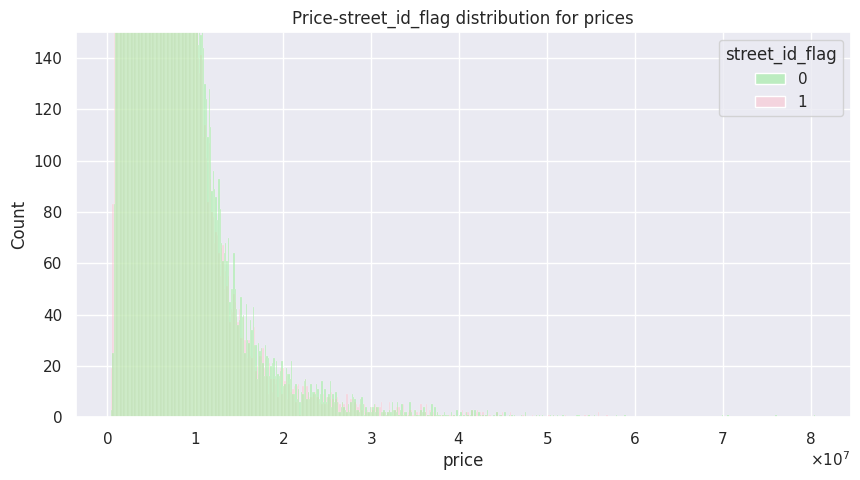

In [ ]:
plot_distribution(ylim=150, hue='street_id_flag')

### No, this is garbage research. But what if we try to calculate the mean for each street_id and make the analysis:

In [58]:
def calculate_means_stddev():
  mean_array = {}
  std_dev_array = {}
  for street_id in prices_dataset['street_id'].unique():
      prices = prices_dataset[prices_dataset['street_id'] == street_id]['price']
      mean_array.update({street_id : prices.mean()})
      std_dev_array.update({street_id : prices.std()})
      # break
  return mean_array, std_dev_array

mean_stddev = calculate_means_stddev()

In [59]:
type(mean_stddev[0])

dict

In [60]:
len(mean_stddev[0]), len(mean_stddev[1])

(672, 672)

In [ ]:
max(mean_stddev[0].values()), min(mean_stddev[0].values())

(19440871.21212121, 1253658.9147286823)

In [ ]:
type(mean_stddev[0].values())

dict_values

Text(0, 0.5, 'Price')

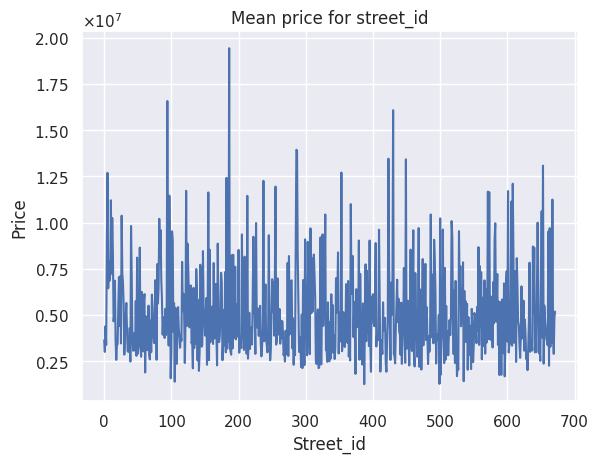

In [64]:
dict_street_id = mean_stddev[0]
ordered_dict_street_id = collections.OrderedDict(sorted(dict_street_id.items()))
sns.lineplot(x = ordered_dict_street_id.keys(), y = ordered_dict_street_id.values())
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Mean price for street_id')
plt.xlabel('Street_id')
plt.ylabel('Price')

### So, there's heterogenity right there.

### We may see that some street_id has great average flat cost than others. Distribution of means will show us this:

<ipython-input-197-9ecce464b1b5>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)


Text(0.5, 1.0, "Mean ID cost's distribution")

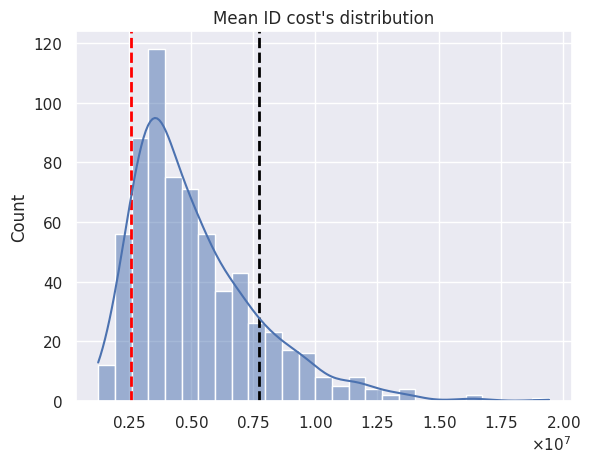

In [ ]:
plt.gca().xaxis.set_major_formatter(formatter)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.1), color = 'red', linestyle = 'dashed',
            linewidth = 2)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.85), color = 'black', linestyle = 'dashed',
            linewidth = 2)
sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)

plt.title("Mean ID cost's distribution")

(0.0, 100.0)

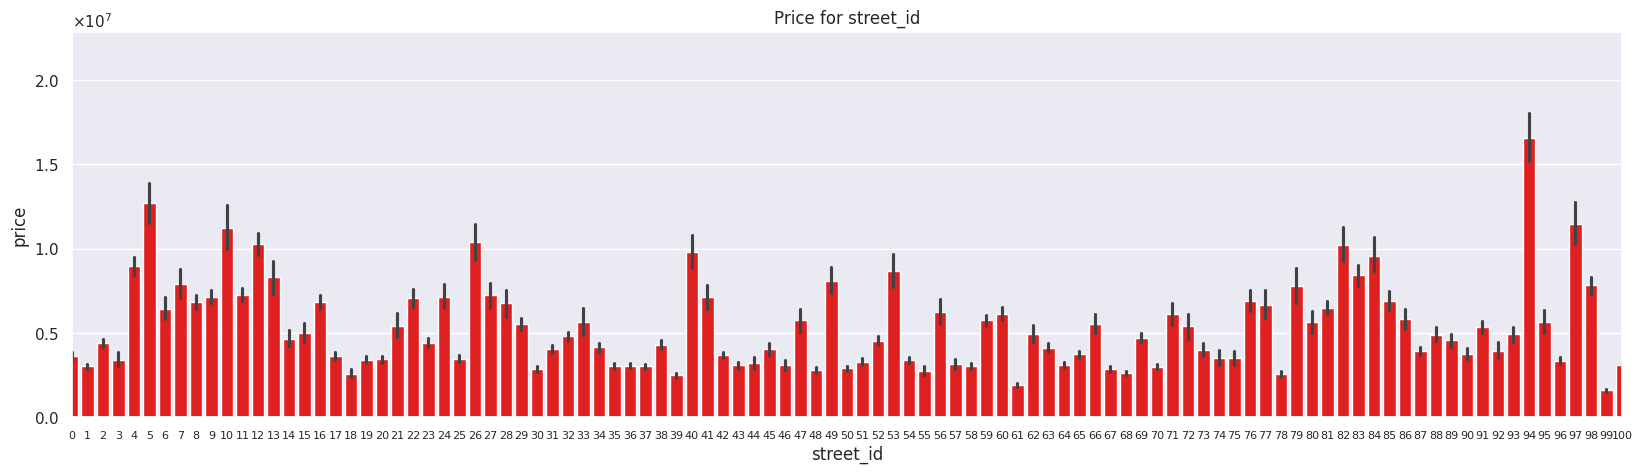

In [101]:
plt.figure(figsize = (20, 5))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Price for street_id')
# plt.axhline(y = 0.7*10**7, color = 'blue', linestyle = '--', linewidth = 2)
sns.barplot(data = prices_dataset, x = 'street_id', y = 'price', color = 'red')
plt.xticks(fontsize = 8)
plt.xlim([0, 100])

### As we see, some street_id's are expensive and some not. But if we'll try to One-hot encode this feature we'll get extra 672 features. That's much. I'll try to divide the street on groups. Or... I'm more into Hashing Trick usage there.

### I gonna try to make 3 street_id ranges:
1. Expensive streets => less than 10% quantile.
2. Middle streets => greater than 10% but less than 76% quantile.
3. Cheap streets => greater than 76% quantile.

### Let's decode this logic:

In [ ]:
len(list(mean_stddev[0].values()))

672

In [ ]:
def create_street_groups(dict_):
  array = list(dict_.values())
  groups_street_id = {}
  for i in range(len(array)):
    if array[i] < np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 1
    elif np.quantile(array, 0.85) > array[i] >= np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 2
    else:
      groups_street_id[list(dict_.keys())[i]] = 3
  return groups_street_id

group_distribution = create_street_groups(mean_stddev[0])

In [ ]:
len(group_distribution)

672

In [ ]:
prices_dataset = prices_dataset.drop(columns = ['street_id_flag'])

In [ ]:
prices_dataset['street_group'] = prices_dataset['street_id'].map(group_distribution)

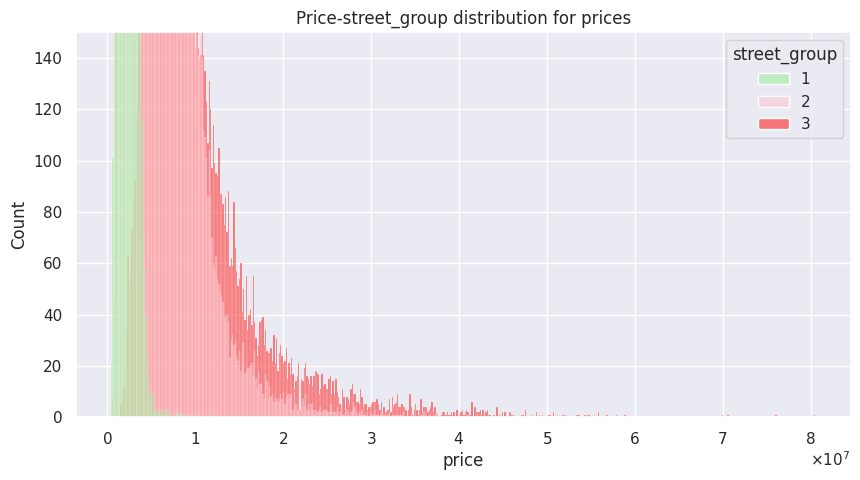

In [ ]:
plot_distribution(150, hue = 'street_group')

### Awesome: I got what I needed! Save & continue tomorrow!

In [ ]:
prices_dataset.to_csv('first_update_predict_prices.csv')

### Let's keep fit & go on!

In [65]:
prices_dataset = pd.read_csv('first_update_predict_prices.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

In [5]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw8,kw9,kw10,kw11,kw12,kw13,price,flag_before_after,three_periods,street_group
0,2011-04-01,0,NaN,5,61,3,0,25.0,NaN,1,...,0,0,0,0,0,0,4294000,0,1,2
1,2011-03-01,0,0.0,3,31,1,0,30.0,1.0,2,...,0,0,0,0,0,0,1572000,0,1,2
2,2011-12-01,0,0.0,6,63,3,0,15.0,0.0,2,...,0,0,0,0,0,0,5380000,1,2,2
3,2011-07-01,0,1.0,1,61,3,1,10.0,NaN,7,...,0,0,0,0,0,0,6106000,0,2,2
4,2011-12-01,0,1.0,1,34,1,0,20.0,0.0,4,...,0,0,0,0,0,0,3805000,1,2,2


### Let's process the 'build_tech' column. There are a lot of NaN values and that's interesting how to deal with it:

In [66]:
build_tech = prices_dataset['build_tech']
build_tech_nan = prices_dataset['build_tech'][prices_dataset['build_tech'].isna() == True]
build_tech_0 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 0]
build_tech_1 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 1]
build_tech_2 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 2]
print(f'Length of total: {len(build_tech)}')
print(f'Length of tech_0: {len(build_tech_0)}')
print(f'Length of tech_1: {len(build_tech_1)}')
print(f'Length of tech_2: {len(build_tech_2)}')
print(f'Length of NaN: {len(build_tech_nan)}')

Length of total: 100000
Length of tech_0: 35845
Length of tech_1: 31611
Length of tech_2: 2809
Length of NaN: 29735


### Around of 30 % are NaN... Let's have a look whether it impact on target feature?

In [67]:
build_tech_nan_data = prices_dataset[prices_dataset['build_tech'].isna() == True]

In [10]:
build_tech_nan_data.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw8,kw9,kw10,kw11,kw12,kw13,price,flag_before_after,three_periods,street_group
0,2011-04-01,0,NaN,5,61,3,0,25.0,NaN,1,...,0,0,0,0,0,0,4294000,0,1,2
9,2012-11-01,0,NaN,9,61,3,0,30.0,0.0,4,...,0,0,0,0,0,0,4217000,1,3,2
12,2012-02-01,0,NaN,2,34,1,0,15.0,0.0,3,...,0,0,0,0,0,0,3155000,1,2,2
22,2012-01-01,0,NaN,7,59,3,0,30.0,0.0,2,...,0,0,0,0,0,0,4944000,1,2,2
29,2011-06-01,0,NaN,1,34,1,0,25.0,0.0,0,...,0,0,0,0,0,0,2304000,0,2,2


<ipython-input-27-37ed7fd3ffc6>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = build_tech_nan_data, x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 0.5, kde = True)


(0.0, 1000.0)

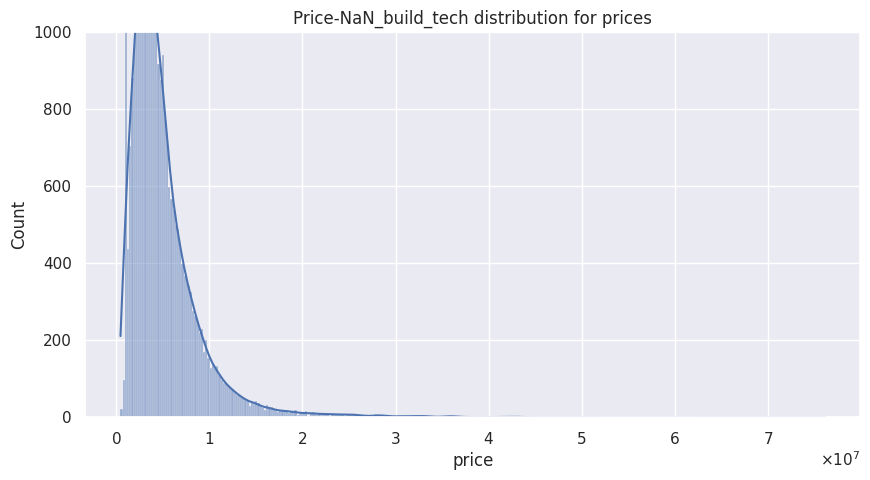

In [27]:
figure = plt.figure(figsize = (10, 5))

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = build_tech_nan_data, x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 0.5, kde = True)
plt.title(f'Price-NaN_build_tech distribution for prices')
plt.ylim([0, 1000])

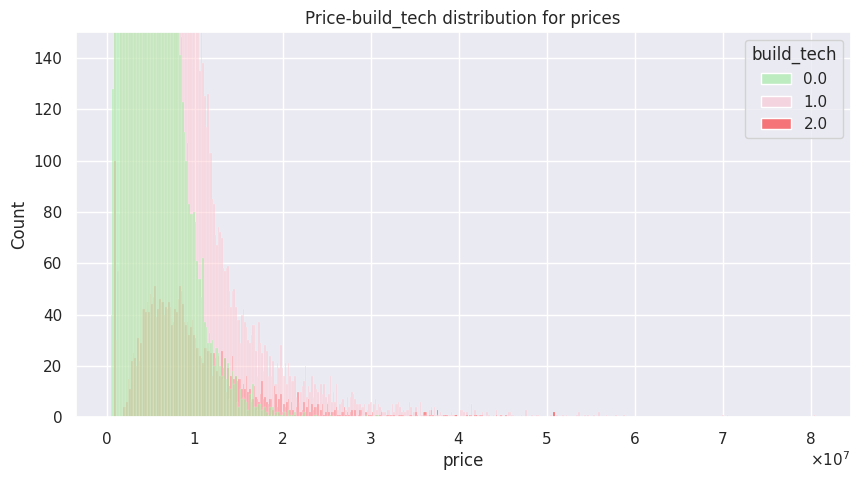

In [19]:
plot_distribution(ylim = 150, hue = 'build_tech')

### So, we actually see that NaN values could be in 3 tech-classes both but...

### But I'm going to fit another technique. Let's assume that the main features corresponding to flats build_tech are area & price. I'll try to build-up Nearest Neighbors Model based on numerical features and try to classify NaN values whether they are build_tech or not!
### Let's implement it:

In [68]:
prices_dataset_build_tech_fit = prices_dataset[['area', 'price', 'build_tech']]
prices_dataset_build_tech_fit.head()

,area,price,build_tech
0,61,4294000,NaN
1,31,1572000,0.0
2,63,5380000,0.0
3,61,6106000,1.0
4,34,3805000,1.0


In [69]:
X_train_build_tech = prices_dataset_build_tech_fit[prices_dataset_build_tech_fit['build_tech'].isna() == False]
X_implement_build_tech = prices_dataset_build_tech_fit[prices_dataset_build_tech_fit['build_tech'].isna() == True]
Y_train_build_tech = X_train_build_tech['build_tech']
X_train_build_tech = X_train_build_tech.drop(columns = ['build_tech'])
X_implement_build_tech = X_implement_build_tech.drop(columns = ['build_tech'])

In [30]:
X_train_build_tech.head()

,area,price
1,31,1572000
2,63,5380000
3,61,6106000
4,34,3805000
5,59,4472000


In [87]:
X_implement_build_tech.head()

,area,price
0,61,4294000
9,61,4217000
12,34,3155000
22,59,4944000
29,34,2304000


In [32]:
Y_train_build_tech.head()

1    0.0
2    0.0
3    1.0
4    1.0
5    0.0
Name: build_tech, dtype: float64

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_build_tech, Y_train_build_tech, test_size = 0.2,
                                                    random_state = 42)

### Ok, let's have a try!

In [69]:
knn_build_tech = KNeighborsClassifier(n_neighbors=11)
knn_build_tech.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=11)

In [70]:
print(classification_report(y_true = Y_test, y_pred = knn_build_tech.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.68      0.67      0.67      7216
         1.0       0.59      0.65      0.62      6265
         2.0       0.29      0.02      0.03       572

    accuracy                           0.63     14053
   macro avg       0.52      0.44      0.44     14053
weighted avg       0.62      0.63      0.62     14053



In [66]:
Y_train_build_tech.unique()

array([0., 1., 2.])

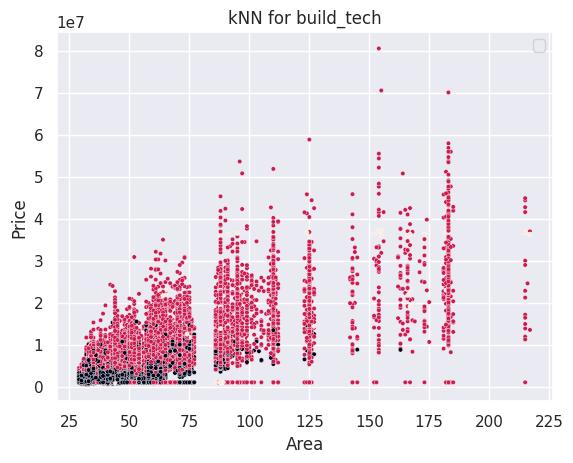

In [71]:
y_pred_build_tech = knn_build_tech.predict(X_train_build_tech)
plt.figure()
sns.scatterplot(x = X_train_build_tech.iloc[:, 0],
                y = X_train_build_tech.iloc[:, 1],  c = y_pred_build_tech, s=10)
plt.title('kNN for build_tech')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

### May be with RandomForest...

In [71]:
rf_build_tech = RandomForestClassifier(max_depth = 25)
rf_build_tech.fit(X_train, Y_train)

RandomForestClassifier(max_depth=25)

In [77]:
print(classification_report(y_true = Y_test, y_pred = rf_build_tech.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      7216
         1.0       0.74      0.76      0.75      6265
         2.0       0.61      0.50      0.55       572

    accuracy                           0.77     14053
   macro avg       0.72      0.69      0.70     14053
weighted avg       0.77      0.77      0.77     14053



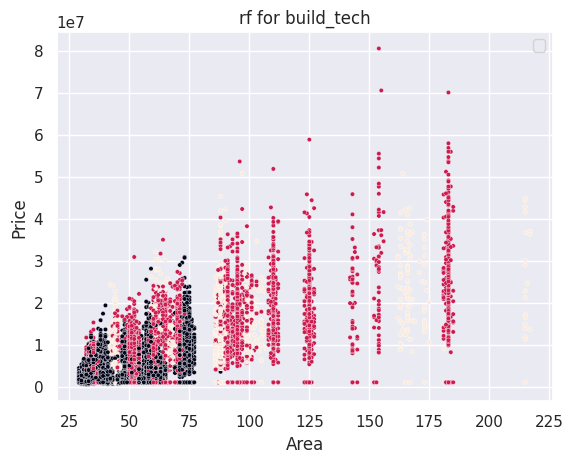

In [15]:
y_pred_build_tech = rf_build_tech.predict(X_train_build_tech)
plt.figure()
sns.scatterplot(x = X_train_build_tech.iloc[:, 0],
                y = X_train_build_tech.iloc[:, 1],  c = y_pred_build_tech, s=10)
plt.title('rf for build_tech')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

### So, actually there are some division between build_tech classes depending on area and price both. So, I'll use RF to replace NaN values as:

In [72]:
predicted_for_NaN = rf_build_tech.predict(X_implement_build_tech)

In [73]:
X_implement_build_tech['predicted_build_tech'] = predicted_for_NaN
X_implement_build_tech.head()

,area,price,predicted_build_tech
0,61,4294000,1.0
9,61,4217000,1.0
12,34,3155000,1.0
22,59,4944000,0.0
29,34,2304000,0.0


### Ok, rather strange heuristic (от лукавого), but let's replace NaNs:

In [74]:
prices_dataset['build_tech'] = prices_dataset['build_tech'].fillna(pd.Series(predicted_for_NaN))
# prices_dataset.head()

### Ok, we did that. Let's dive into another feature: ***Floor***

In [75]:
floor = prices_dataset['floor']
print(f"Unique values for floor: {' '.join([str(floor) for floor in floor.unique()])}")
print(f'Number of Unique values: {len(floor.unique())}')

Unique values for floor: 5 3 6 1 12 2 9 4 7 11 10 8 23 21 18 20 14 25 13 22 19 16 15 17 24
Number of Unique values: 25


In [76]:
floor[floor.isna() == True]

Series([], Name: floor, dtype: int64)

### So, according to the РБК post, difference in price for down and up floors could be in order of 37%. Of course, depends on class and other features, but let's have a look how's this fact presented in our data:

### For example, let's take flats with floor <=4, floor in (4, 10] and >10 and count mean_value:

In [77]:
flats_down = prices_dataset[prices_dataset['floor'] <= 3]
flats_up = prices_dataset[prices_dataset['floor'] > 10]
flats_middle = prices_dataset[(prices_dataset['floor'] <= 10) & (prices_dataset['floor'] > 3)]

print(f'Number down flats: {len(flats_down)}')
print(f'Number middle flats: {len(flats_middle)}')
print(f'Number up flats: {len(flats_up)}')

Number down flats: 39003
Number middle flats: 50941
Number up flats: 10056


In [78]:
flats_up['price'].head()

6      1000000
21     4259000
30     6058000
139    3366000
158    1870000
Name: price, dtype: int64

In [79]:
print(f'Mean price for down flats: {flats_down["price"].mean()}')
print(f'Mean price for up flats: {flats_up["price"].mean()}')
print(f'Mean price for middle flats: {flats_middle["price"].mean()}')

Mean price for down flats: 4533920.493295387
Mean price for up flats: 7060338.703261734
Mean price for middle flats: 5221812.037455095


### So, the higher -> the more expensive in average.

In [80]:
print(f'Std for down flats: {flats_down["price"].std()}')
print(f'Std for up flats: {flats_up["price"].std()}')
print(f'Std for middle flats: {flats_middle["price"].std()}')

Std for down flats: 3458401.282360918
Std for up flats: 5282688.300420626
Std for middle flats: 4329011.476962485


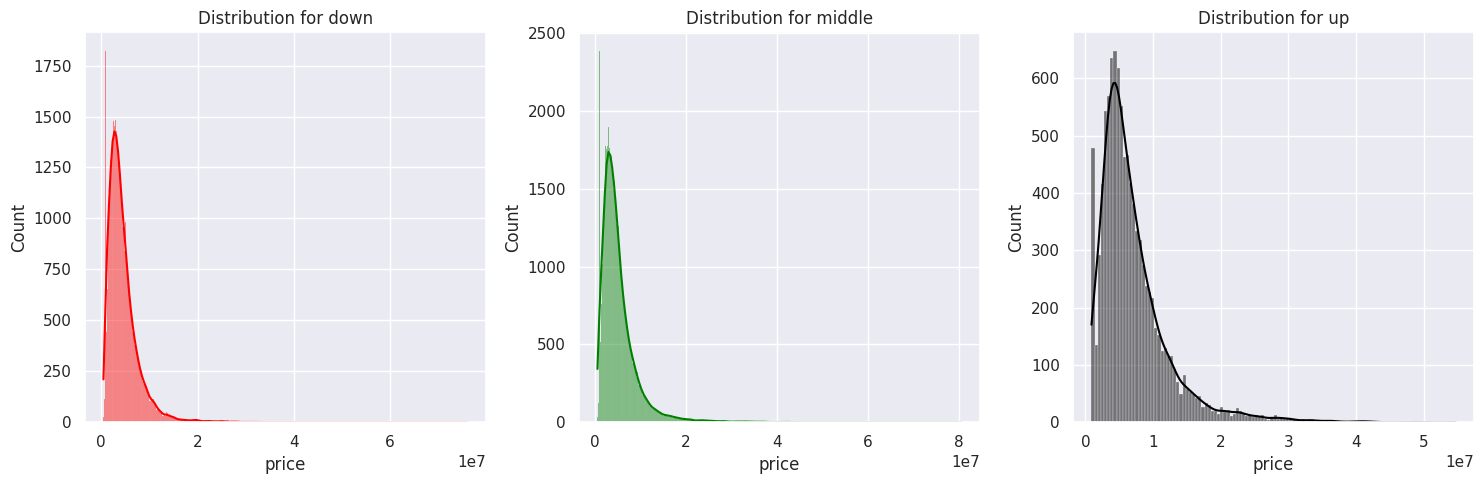

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(flats_down['price'], ax=axes[0], kde=True, color = 'red')
sns.histplot(flats_middle['price'], ax=axes[1], kde=True, color = 'green')
sns.histplot(flats_up['price'], ax=axes[2], kde=True, color = 'black')

axes[0].set_title('Distribution for down')
axes[1].set_title('Distribution for middle')
axes[2].set_title('Distribution for up')

plt.tight_layout()
plt.show()

(0.0, 1800.0)

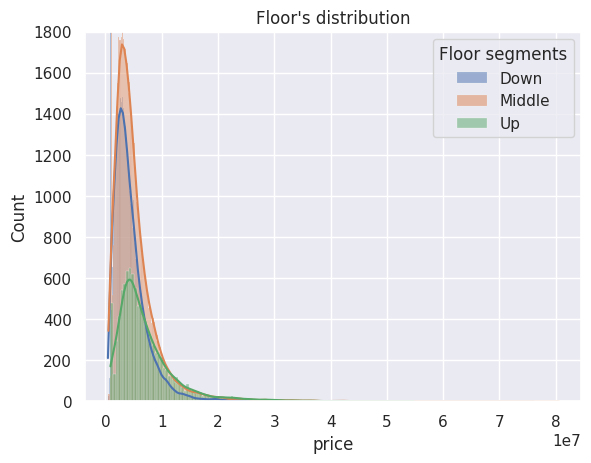

In [84]:
sns.histplot(flats_down['price'], kde=True, label = 'Down')
sns.histplot(flats_middle['price'], kde=True, label = 'Middle')
sns.histplot(flats_up['price'], kde=True, label = 'Up')

plt.legend(title = 'Floor segments')
plt.title("Floor's distribution")
plt.ylim([0, 1800])

(0.0, 800.0)

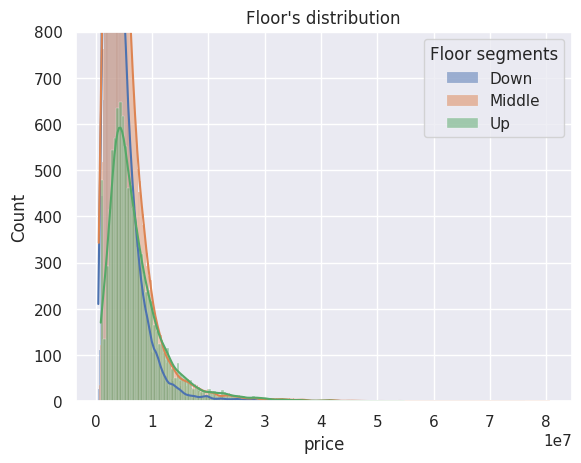

In [85]:
sns.histplot(flats_down['price'], kde=True, label = 'Down')
sns.histplot(flats_middle['price'], kde=True, label = 'Middle')
sns.histplot(flats_up['price'], kde=True, label = 'Up')

plt.legend(title = 'Floor segments')
plt.title("Floor's distribution")
plt.ylim([0, 800])

### Let's denote how's the prices for min & max floor differ:

In [28]:
min_floor = floor.unique().min()
max_floor = floor.unique().max()

flats_min = prices_dataset[prices_dataset['floor'] == min_floor]
flats_max = prices_dataset[prices_dataset['floor'] == max_floor]

print(f'Number of min_floor flats: {len(flats_min)}')
print(f'Mean of max_floor flats: {len(flats_max)}')

print(f'Mean price for min_floor flats: {flats_min["price"].mean()}')
print(f'Mean price for max_floor flats: {flats_max["price"].mean()}')

Number of min_floor flats: 12951
Mean of max_floor flats: 207
Mean price for min_floor flats: 4263849.200833912
Mean price for max_floor flats: 7839391.304347826


In [40]:
floors_sorted = sorted(np.asarray(floor.unique()))

In [46]:
means_array = []
for floor in floors_sorted:
  flats_floor = prices_dataset[prices_dataset['floor'] == floor]
  flats_floor_mean = flats_floor["price"].mean()
  means_array.append(flats_floor_mean)

Text(0, 0.5, 'Price')

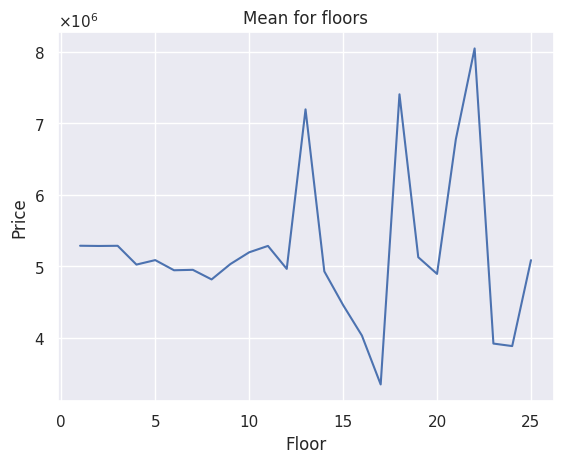

In [88]:
sns.lineplot(x = floors_sorted, y = means_array)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Mean for floors')
plt.xlabel('Floor')
plt.ylabel('Price')

<Axes: title={'center': 'Price for floors'}, xlabel='floor', ylabel='price'>

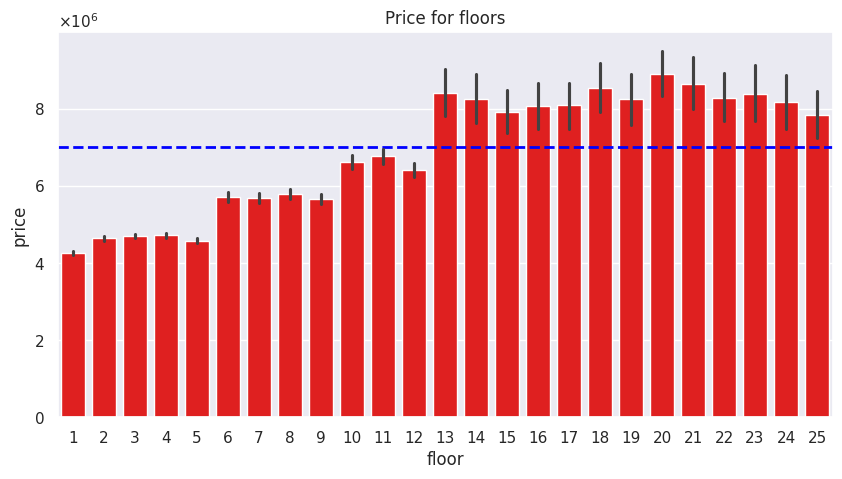

In [94]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Price for floors')
plt.axhline(y = 0.7*10**7, color = 'blue', linestyle = '--', linewidth = 2)
sns.barplot(data = prices_dataset, x = 'floor', y = 'price', color = 'red')

### In general(3 floor ranges: down, middle & up) it's not so significant imho. Also on the total trend there's something like impurity. But barplot shows that down floors are cheaper than up. So, probably I'll apply the Hashing Trick technique for this feature and will work with it as it's cathegorical.

### So, have a break & continue!

In [87]:
prices_dataset.to_csv('second_update_predict_prices.csv')

In [110]:
prices_dataset = pd.read_csv('second_update_predict_prices.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

### Continue with area:

In [111]:
prices_area = prices_dataset['area']

print(f'Number of NaN values: {len(prices_area[prices_area.isna() == True])}')

Number of NaN values: 0


### What about distribution?

Text(0.5, 1.0, 'Area Distribution')

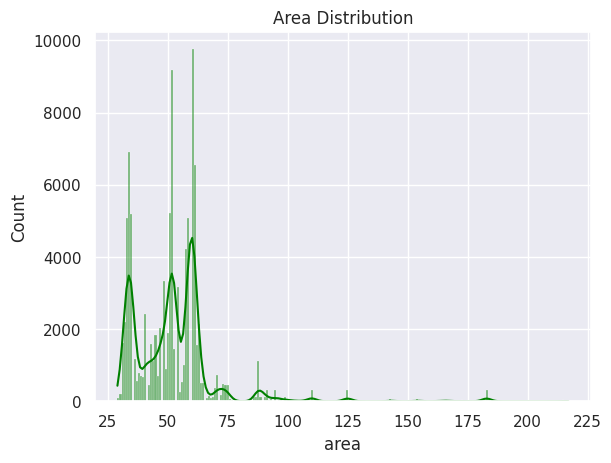

In [112]:
sns.histplot(x = prices_dataset['area'], color = 'green', kde = True)
plt.title('Area Distribution')

(0.0, 3000.0)

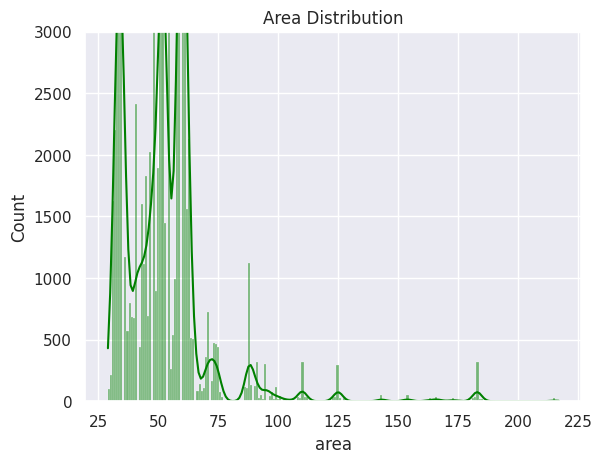

In [115]:
sns.histplot(x = prices_dataset['area'], color = 'green', kde = True)
plt.title('Area Distribution')
plt.ylim([0, 3000])

### Let's calculate some correlations:

In [117]:
area_price_corr = prices_dataset['area'].corr(prices_dataset['price'])
print(f"Correlation between area & price: {area_price_corr}")

Correlation between area & price: 0.6626614061799292


In [119]:
area_dist_corr = prices_dataset['area'].corr(prices_dataset['metro_dist'])
print(f"Correlation between area & metro_dist: {area_dist_corr}")

Correlation between area & metro_dist: 0.005430918834783408


In [120]:
area_rooms_corr = prices_dataset['area'].corr(prices_dataset['rooms'])
print(f"Correlation between area & rooms number: {area_rooms_corr}")

Correlation between area & rooms number: 0.7918293451334185


### So, I guess that's significant correlation (as it was expected: the more $m^{2}$ the more expensive the flat). Also we may notice strong correlation between the rooms number and area (likewise expected). Further we should deal with it.

### Ok, go on. ***Rooms*** :

In [128]:
rooms_unique = np.asarray(prices_dataset['rooms'].unique())

print(f"Unique number of rooms: {' '.join([str(room) for room in rooms_unique])}")
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['rooms'].isna() == True]) }")

Unique number of rooms: 3 1 2 4 5 6
Number of NaN values: 0


Text(0.5, 1.0, 'Rooms-price Barplot')

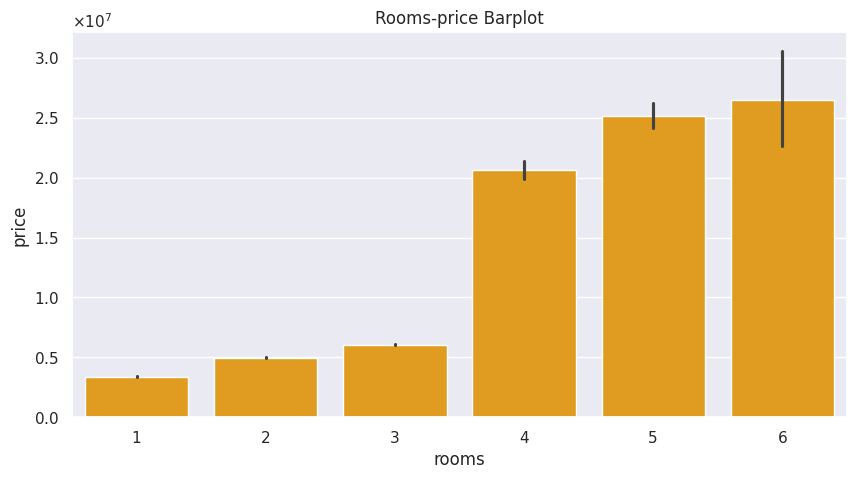

In [129]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'rooms', y = 'price', color = 'orange')
plt.title('Rooms-price Barplot')

### Of course, that's expected. The more rooms the greater the cost.

In [132]:
for i in range(1, 7):
  print(np.exp(i))

2.718281828459045
7.38905609893065
20.085536923187668
54.598150033144236
148.4131591025766
403.4287934927351


In [133]:
for i in range(1, 7):
  print(np.log(i))

0.0
0.6931471805599453
1.0986122886681098
1.3862943611198906
1.6094379124341003
1.791759469228055


### Probably it's useful to make $exp(rooms\_number)$ to show the real difference between number of rooms (or $\ln (rooms\_number)$).
### ¡It's **NOT** cathegorical feature at all!

### Let's go for a ***balcon*** :

In [134]:
balconies_unique = np.asarray(prices_dataset['balcon'].unique())

print(f"Unique number of balconies: {' '.join([str(balcon) for balcon in balconies_unique])}")
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['balcon'].isna() == True]) }")

Unique number of balconies: 0 1 2
Number of NaN values: 0


Text(0.5, 1.0, 'Balconies-price Barplot')

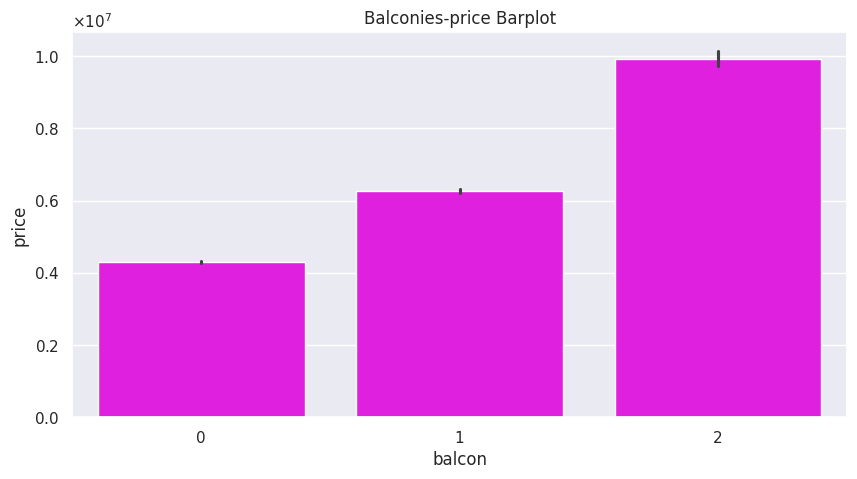

In [140]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'balcon', y = 'price', color = 'magenta')
plt.title('Balconies-price Barplot')

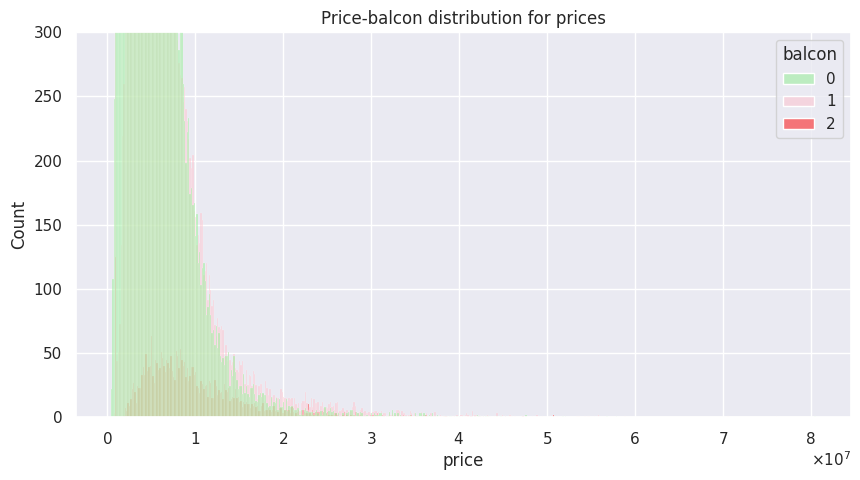

In [142]:
plot_distribution(ylim = 300, hue = 'balcon')

### Some correlations:

In [143]:
area_balcon_corr = prices_dataset['area'].corr(prices_dataset['balcon'])
print(f"Correlation between area & balconies number: {area_balcon_corr}")

Correlation between area & balconies number: 0.25676900679093057


In [144]:
price_balcon_corr = prices_dataset['price'].corr(prices_dataset['balcon'])
print(f"Correlation between price & balconies number: {price_balcon_corr}")

Correlation between price & balconies number: 0.29224166525504947


>Study note: There's impact on target.

In [145]:
rooms_balcon_corr = prices_dataset['rooms'].corr(prices_dataset['balcon'])
print(f"Correlation between rooms & balconies number: {rooms_balcon_corr}")

Correlation between rooms & balconies number: 0.10074615510215011


### So, I guess it's not cathegorical feature at all. Probably, I'll use $\ln()$ or $\exp()$ transform.

### Continue with ***metro_dist*** :

In [149]:
prices_metro_dist = prices_dataset['metro_dist']
prices_metro_dist.head()

0    25.0
1    30.0
2    15.0
3    10.0
4    20.0
Name: metro_dist, dtype: float64

In [150]:
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['metro_dist'].isna() == True]) }")

Number of NaN values: 4896


### Ok, we have 4896 NaN metro_distances. We should deal with it.

### Let's have a look how's metro_distance impacts on price:

In [159]:
non_nan_metro_dist = prices_dataset[prices_dataset['metro_dist'].isna() == False]
# non_nan_metro_dist.head()
print(f'Number of non-NaN examples: {len(non_nan_metro_dist)}')
dist_price_corr = non_nan_metro_dist['metro_dist'].corr(non_nan_metro_dist['price'])
print(f'Correlation between metro_dist and price: {dist_price_corr}')

Number of non-NaN examples: 95104
Correlation between metro_dist and price: -0.09226999778115152


<Axes: xlabel='metro_dist', ylabel='Count'>

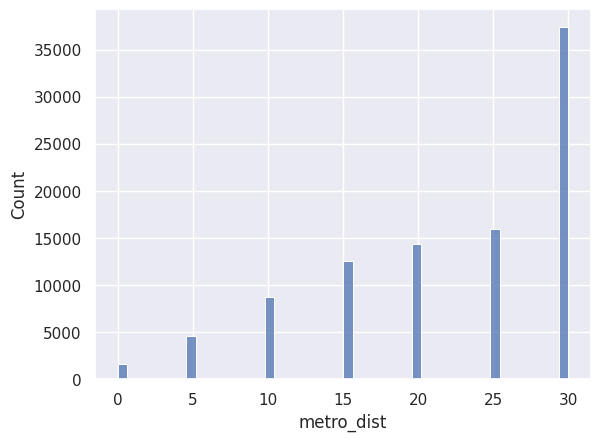

In [161]:
sns.histplot(x = non_nan_metro_dist['metro_dist'])

### So, the correlation is low. And, actually not so a lot unique values. That's why I guess, we may replace it by mean value.

In [163]:
prices_dataset['metro_dist'] = prices_dataset['metro_dist'].fillna(prices_dataset['metro_dist'].mean())
non_nan_metro_dist_update = prices_dataset[prices_dataset['metro_dist'].isna() == False]
print(f'Number of non-NaN examples *update*: {len(non_nan_metro_dist_update)}')

Number of non-NaN examples *update*: 100000


### Some break & continue.